In [1]:
'''Special thanks to
1) https://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense
2)
''' 
# Libraries for working with data
import numpy as np 
import pandas as pd

# libraries for visualizing data
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#########################################################
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
#Loading dataset
train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-jan-2022/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [4]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [5]:
# converting date into time series data
train['date'] = pd.to_datetime(train.date)
test['date'] = pd.to_datetime(test.date)

In [6]:
# duration 
print(f'Training data is from {train.date.min()} to {train.date.max()} duration {train.date.max()-train.date.min()} ')
print(f'Testing  data is from {test.date.min()} to {test.date.max()} duration  {test.date.max()-test.date.min()} ')

Training data is from 2015-01-01 00:00:00 to 2018-12-31 00:00:00 duration 1460 days 00:00:00 
Testing  data is from 2019-01-01 00:00:00 to 2019-12-31 00:00:00 duration  364 days 00:00:00 


In [7]:
for col in ['country', 'store','product']:
    print(f'{col}: {train[col].unique()}')


country: ['Finland' 'Norway' 'Sweden']
store: ['KaggleMart' 'KaggleRama']
product: ['Kaggle Mug' 'Kaggle Hat' 'Kaggle Sticker']


In [8]:
train_categories = train.groupby(['country','store','product']).agg({'num_sold': ['min','max','mean']}) 
train_categories.head()

num_sold                  
                                       min   max        mean
country store      product                                  
Finland KaggleMart Kaggle Hat          210  1113  362.479808
                   Kaggle Mug          126   774  204.200548
                   Kaggle Sticker       70   326  103.044490
        KaggleRama Kaggle Hat          354  1895  628.926762
                   Kaggle Mug          220  1398  356.110883

In [9]:
train_data_year = train.pivot_table(index=pd.Grouper(freq='Y',key='date')).reset_index().drop(columns='row_id',axis=0)
train_data_year.head()

,date,num_sold
0,2015-12-31,364.382192
1,2016-12-31,364.807529
2,2017-12-31,396.011720
3,2018-12-31,424.995129


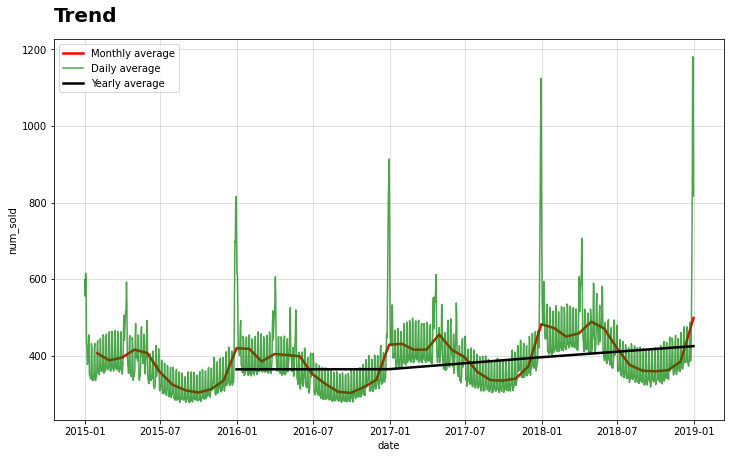

In [10]:
#using seaborn
train_data_year = train.set_index('date').groupby([pd.Grouper(freq='Y')])['num_sold'].mean().reset_index()
train_data_month = train.set_index('date').groupby([pd.Grouper(freq='M')])['num_sold'].mean().reset_index()
train_data_day = train.set_index('date').groupby([pd.Grouper(freq='d')])['num_sold'].mean().reset_index()
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(data=train_data_month,x='date',y='num_sold' ,label='Monthly average', color='red',linewidth=2.5)
sns.lineplot(data=train_data_day,x='date',y='num_sold' ,label='Daily average', color='green',alpha=.7)
sns.lineplot(data=train_data_year,x='date',y='num_sold',ax=ax, label='Yearly average', color='black',linewidth=2.5)
ax.set_title('Trend', fontsize=20, fontweight='bold', loc='left', y=1.03)
ax.grid(alpha=0.5)
ax.legend()
plt.show()



In [11]:
#using plotly
train_data_month = train.set_index('date').groupby([pd.Grouper(freq='7d')])['num_sold'].mean().reset_index()
a = px.line(data_frame=train_data_month,x='date',y='num_sold')
a.show()

## Preprocessing and visualization 

In [12]:
country_daily = train.groupby(['date','country'])['num_sold'].sum().reset_index(level=[0,1])
for country in train['country'].unique():
    display(country_daily[country_daily['country']==country].sort_values(by=['num_sold'], ascending=False).head())

,date,country,num_sold
4374,2018-12-29,Finland,6029
4377,2018-12-30,Finland,5869
3282,2017-12-30,Finland,5611
3285,2017-12-31,Finland,4683
3279,2017-12-29,Finland,4650


,date,country,num_sold
4378,2018-12-30,Norway,8980
4375,2018-12-29,Norway,8855
3283,2017-12-30,Norway,8388
3286,2017-12-31,Norway,7433
3280,2017-12-29,Norway,7018


,date,country,num_sold
4376,2018-12-29,Sweden,6377
3284,2017-12-30,Sweden,6248
4379,2018-12-30,Sweden,6227
3287,2017-12-31,Sweden,5488
3281,2017-12-29,Sweden,5205


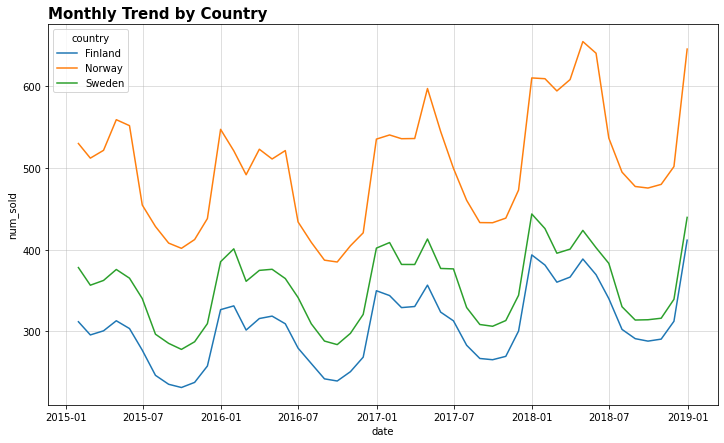

In [13]:
#using seaborn
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
train_monthly_country = train.set_index('date').groupby([pd.Grouper(freq='M'),'country'])[['num_sold']].mean()
sns.lineplot(x="date", y='num_sold', hue='country', data=train_monthly_country, ax=ax)

ax.set_ylabel('num_sold')
ax.set_title('Monthly Trend by Country', fontsize=15, fontweight='bold', loc='left')
ax.grid(alpha=0.5)
plt.show()

In [14]:
train_monthly_country = train.set_index('date').groupby([pd.Grouper(freq='M'),'country'])[['num_sold']].mean().reset_index()
train_monthly_country.head()

,date,country,num_sold
0,2015-01-31,Finland,311.817204
1,2015-01-31,Norway,529.779570
2,2015-01-31,Sweden,378.064516
3,2015-02-28,Finland,295.702381
4,2015-02-28,Norway,511.892857


In [15]:
#using plotly
train_monthly_country = train.set_index('date').groupby([pd.Grouper(freq='M'),'country'])[['num_sold']].mean().reset_index()
a = px.line(data_frame=train_monthly_country,x='date',y='num_sold',color='country')
a.show()

## Distrubution of product sales on weekends and weekdays

In [16]:
train['dayofweek'] = train['date'].dt.dayofweek
test['dayofweek'] = test['date'].dt.dayofweek

In [17]:
train_dayofweek = train.set_index('date').groupby([pd.Grouper(freq='M'),'dayofweek'])[['num_sold']].mean().reset_index()
a = px.line(data_frame=train_dayofweek,x='date',y='num_sold',color='dayofweek')
a.show()

In [18]:
# and digging deeper
train['weekend'] = train['dayofweek'].apply(lambda x: x >= 4)
train_weekend = train.set_index('date').groupby([pd.Grouper(freq='M'),'weekend'])[['num_sold']].mean().reset_index()
a = px.line(data_frame=train_weekend,x='date',y='num_sold',color='weekend',title='weekday vs weekend trend comparasion')
a.show()

In [19]:
train.head()

,row_id,date,country,store,product,num_sold,dayofweek,weekend
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,3,False
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,3,False
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,3,False
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,3,False
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,3,False


In [20]:
country_dayofweek = pd.pivot_table(train,index='country',columns='dayofweek',values='num_sold',aggfunc=np.mean)
country_dayofweek = pd.DataFrame(country_dayofweek.divide(country_dayofweek.sum(axis=1),axis=0).unstack()).reset_index()
country_dayofweek.rename(columns={0:'num_sold'},inplace=True)
country_dayofweek.head()

,dayofweek,country,num_sold
0,0,Finland,0.131726
1,0,Norway,0.132270
2,0,Sweden,0.131658
3,1,Finland,0.131869
4,1,Norway,0.131490


In [21]:
a = px.bar(data_frame=country_dayofweek,x='dayofweek',y='num_sold',color='country',title='percent of day by week of country')
a.update_layout(barmode='group',
        xaxis = dict(
        tickmode = 'array',
        tickvals = [0,1,2,3,4,5,6],
        ticktext = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    )
               )
a.show()

In [22]:
# Let's see if there is a preference for each country
country_product = pd.pivot_table(data=train,index='country',columns='product',values='num_sold',aggfunc=np.mean)
country_product.divide(country_product.sum(axis=1),axis=0)


product,Kaggle Hat,Kaggle Mug,Kaggle Sticker
country,,,
Finland,0.540278,0.305348,0.154375
Norway,0.540989,0.304714,0.154298
Sweden,0.541298,0.304437,0.154264


In [23]:
# Lest's see if there is a preference for each day of week
country_product = pd.pivot_table(data=train,index='dayofweek',columns='product',values='num_sold',aggfunc=np.mean)
country_product.divide(country_product.sum(axis=1),axis=0)

product,Kaggle Hat,Kaggle Mug,Kaggle Sticker
dayofweek,,,
0,0.540618,0.305092,0.154290
1,0.540861,0.304648,0.154491
2,0.541073,0.304628,0.154299
3,0.541214,0.304677,0.154108
4,0.540796,0.304549,0.154655
5,0.540148,0.305577,0.154275
6,0.541584,0.304332,0.154083


## Lets do some animations

In [24]:
!pip install -qqq bar_chart_race


In [25]:
train_month_country = train.set_index('date').groupby([pd.Grouper(freq='M'), 'country'])['num_sold'].mean().unstack()
import bar_chart_race as bcr
bcr.bar_chart_race(df=train_month_country,
                   n_bars=3,
                   period_length=800,
                   filename=None)

## KaggleRama sells more
* For every country and product, KaggleRama on average sells 1.74 times as much as KaggleMart.

Insight: Maybe it suffices to model KaggleMart and multiply all predictions by 1.74 to get the KaggleRama predictions

In [26]:
k_merchandise = train.groupby(['country','store','product']).num_sold.mean().unstack(level='store')
k_merchandise['Krama:Kmart'] = k_merchandise.KaggleRama / k_merchandise.KaggleMart
k_merchandise.head()


store                   KaggleMart   KaggleRama  Krama:Kmart
country product                                             
Finland Kaggle Hat      362.479808   628.926762     1.735067
        Kaggle Mug      204.200548   356.110883     1.743927
        Kaggle Sticker  103.044490   180.232033     1.749070
Norway  Kaggle Hat      594.645448  1036.357974     1.742817
        Kaggle Mug      334.370294   584.297741     1.747457

## Products
* If we group the data by country, store, product and year, the ratio Sticker:Mug:Hat is always 1:1.97:3.5 and depends neither on country nor on store nor on year. If we group the data by month, however, the ratio is not constant. This implies that the products have different seasonal variations.

**Insight:** We have to model seasonal effects which depend on the product

In [27]:
k_merchandise = train.groupby(['country','product','store']).num_sold.mean().unstack(level='product')
k_merchandise['Mugs/Sticker'] = k_merchandise['Kaggle Mug'] / k_merchandise['Kaggle Sticker']
k_merchandise['Hat/Sticker'] = k_merchandise['Kaggle Hat'] / k_merchandise['Kaggle Sticker']
k_merchandise.head()

product              Kaggle Hat  Kaggle Mug  Kaggle Sticker  Mugs/Sticker  \
country store                                                               
Finland KaggleMart   362.479808  204.200548      103.044490      1.981674   
        KaggleRama   628.926762  356.110883      180.232033      1.975847   
Norway  KaggleMart   594.645448  334.370294      169.577687      1.971782   
        KaggleRama  1036.357974  584.297741      295.607803      1.976598   
Sweden  KaggleMart   419.214237  235.885010      119.613279      1.972064   

product             Hat/Sticker  
country store                    
Finland KaggleMart     3.517702  
        KaggleRama     3.489539  
Norway  KaggleMart     3.506626  
        KaggleRama     3.505855  
Sweden  KaggleMart     3.504747

In [28]:
# Group by month 
k_merchandise = train.groupby(['product',train.date.dt.month]).num_sold.mean().unstack(level='product')
k_merchandise['Mugs/Sticker'] = k_merchandise['Kaggle Mug'] / k_merchandise['Kaggle Sticker']
k_merchandise['Hat/Sticker'] = k_merchandise['Kaggle Hat'] / k_merchandise['Kaggle Sticker']
k_merchandise.head()


product,Kaggle Hat,Kaggle Mug,Kaggle Sticker,Mugs/Sticker,Hat/Sticker
date,,,,,
1,688.612903,419.631720,187.096774,2.242859,3.680517
2,686.278761,372.073746,169.793510,2.191331,4.041843
3,729.115591,353.951613,172.145161,2.056123,4.235470
4,784.891667,352.075000,184.615278,1.907074,4.251499
5,752.611559,329.176075,186.262097,1.767274,4.040605


## Histograms and SMAPE
The histograms for every country-store-product combination show that all histograms are skewed. For every product, there are some days with sales far above the mean. For these outliers, predictions will be much less accurate than for the regular days. This is why the competition is scored by Symmetric mean absolute percentage error (SMAPE) rather than MAE or MSE.

Of course, in a competition scored by SMAPE, we have to carefully choose a loss function for training our models. MSE or MAE are not the ideal loss functions here.

Every product's histogram has a slightly different shape. The histograms of the Kaggle Hat looks wider than the histograms of the other two products.

*Insight*

1.  Choosing a suitable loss function is important.
2. It may be advantageous to predict log(num_sold) rather than num_sold directly.
3. We need more analysis to understand why the histograms have different shapes. Maybe it is because of the seasonal variations, maybe there is something else.

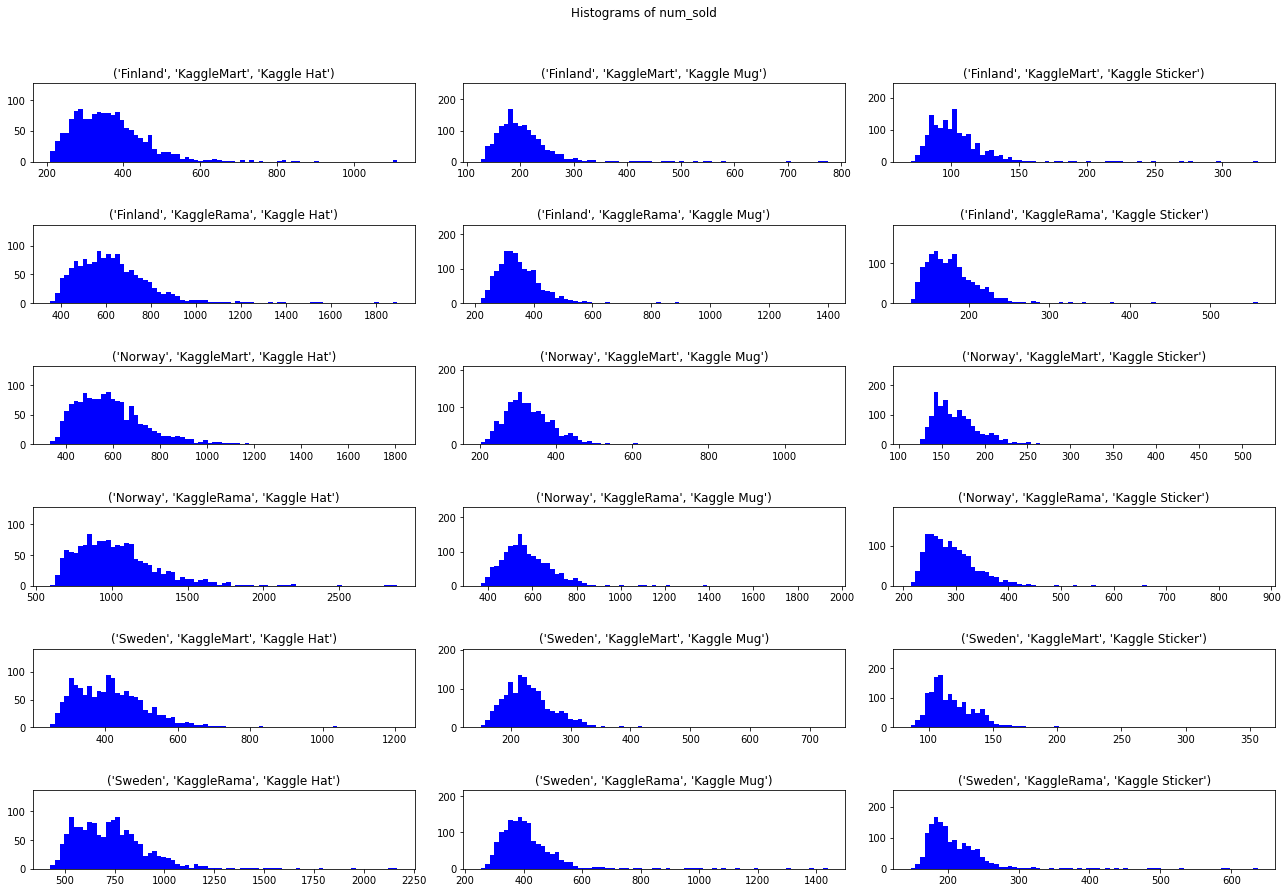

In [29]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=75, color='blue')
    #ax.set_xscale('log')
    ax.set_title(combi)
plt.suptitle('Histograms of num_sold', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

## Time series
* Daily sales and the year-end peak

A plot of the daily values of the 18 four_year time series clearly shows high peaks at the end of every year. If we look at the diagrams closely, we see slight waveforms and discern more seasonal effects:

(left column:) Kaggle sells more hats in the first half of the year than in the second half (maybe because buyers want to wear Kaggle hats during summer).
(middle column:) Demand for mugs is higher in the (northern hemisphere) winter than in summer.
(right column:) Sticker sales don't depend on season, except for some small spikes. (All three products have these spikes in the second quarter.)
Insight

We have to model seasonal effects which depend on the product.
We have to model waves with a wavelength of a year as well as short spikes.

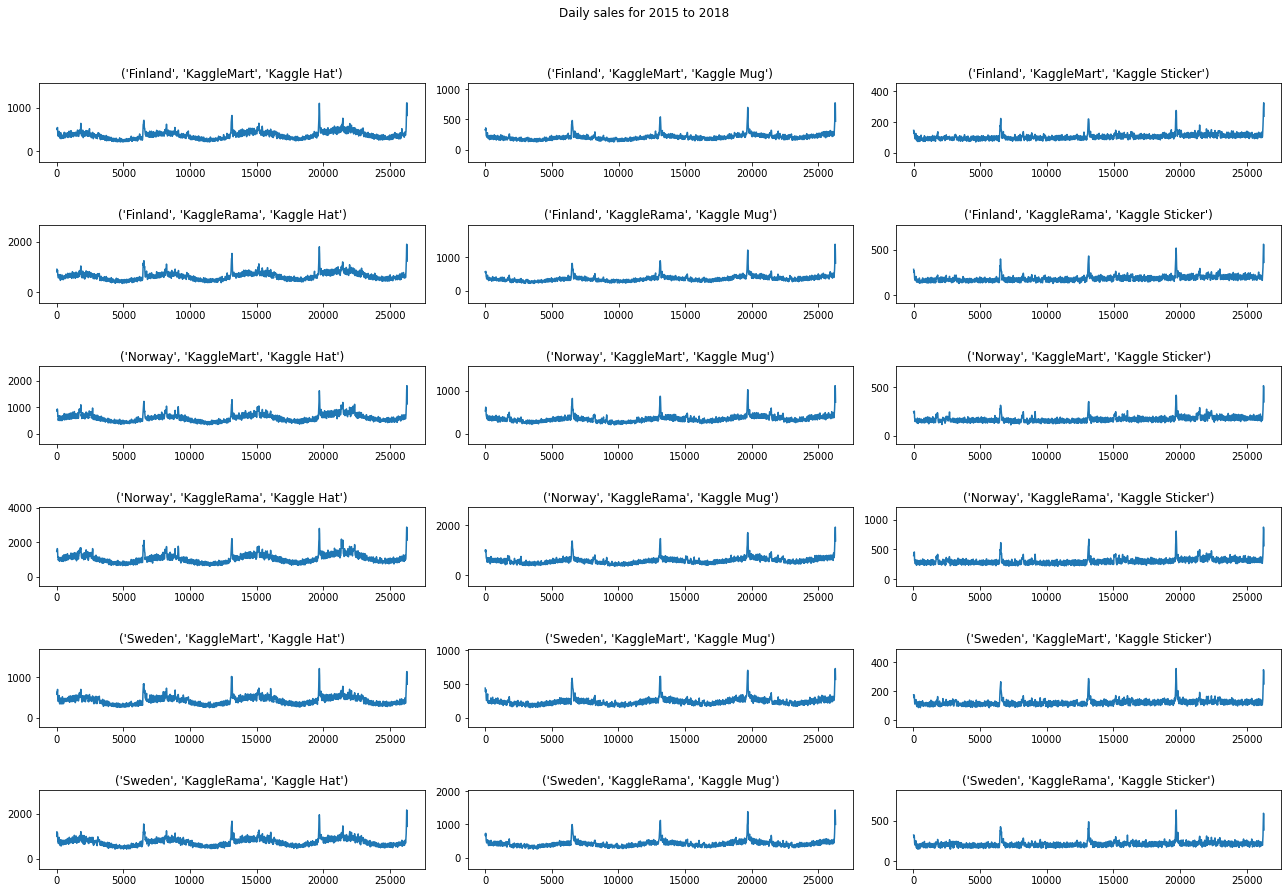

In [30]:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.plot(df.num_sold)
    #ax.set_xscale('log')
    ax.set_title(combi)
plt.suptitle('Daily sales for 2015 to 2018', y=1.03)
plt.tight_layout(h_pad=3.0)
plt.show()

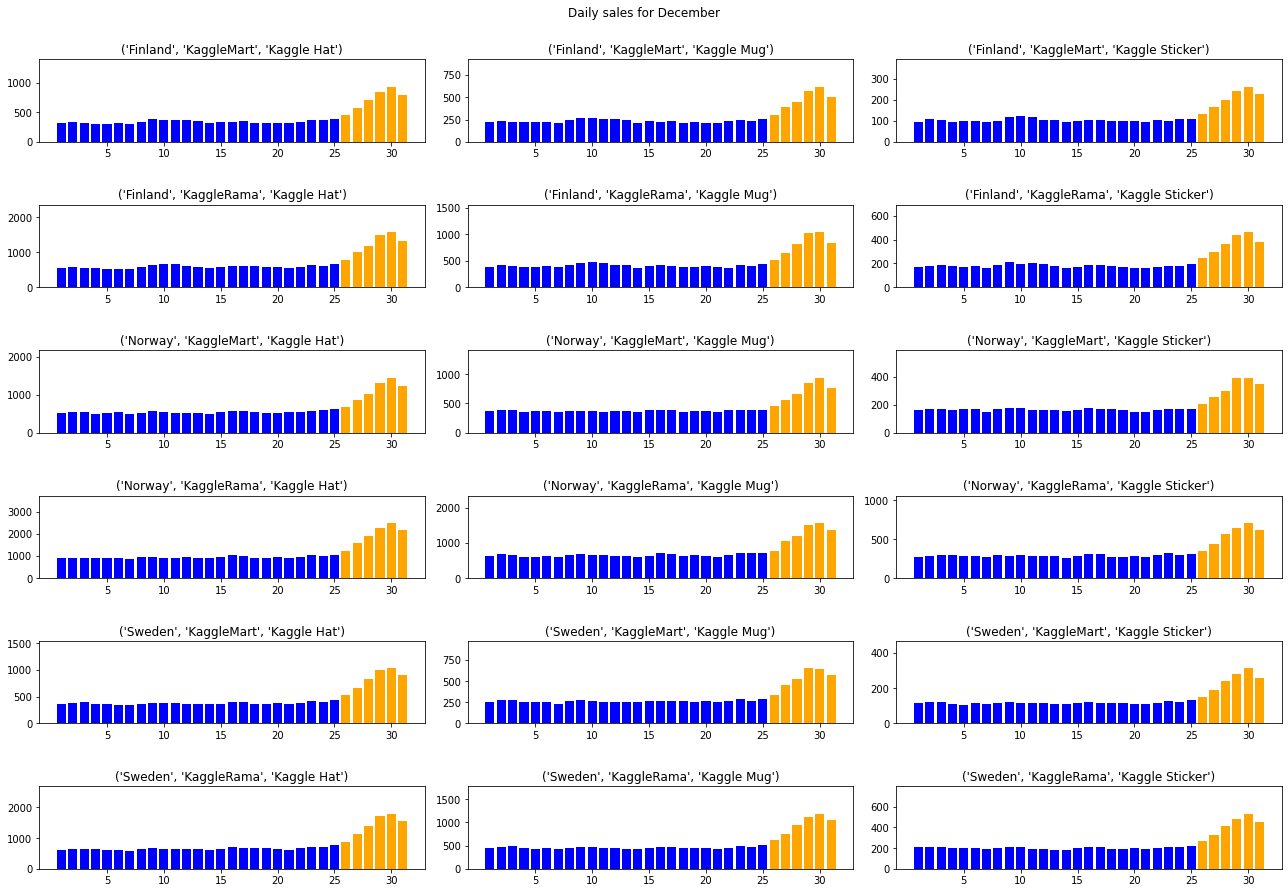

In [31]:
#Let's zoom in on the year-end peak. We plot only the 31 days of December, averaged over the four years. 
#The plots show that sales start growing after Christmas and peak on the 30th of December:
plt.figure(figsize=(18, 12))
for i, (combi, df) in enumerate(train.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(6, 3, i+1, ymargin=0.5)
    ax.bar(range(1, 31+1),
           df.num_sold[df.date.dt.month==12].groupby(df.date.dt.day).mean(),
           color=['b'] * 25 + ['orange'] * 6)
    ax.set_title(combi)
    ax.set_xticks(ticks=range(5, 31, 5))
plt.tight_layout(h_pad=3.0)
plt.suptitle('Daily sales for December', y=1.03)
plt.show()